In [1]:
import tensorflow as tf #предоставляет инструменты для создания и обучения нейронных сетей под различные задачи по обработки данных
from tensorflow.keras import layers, Model #keras позволяет быстрее создавать и настраивать модели, предобрабатывать данные
from tensorflow.keras.preprocessing.text import Tokenizer #токенайзер для разбивки вопросов на отдельные слова
from tensorflow.keras.preprocessing.sequence import pad_sequences #преобразует список предложений в двумерный массив NumPy определенного размера
from sklearn.preprocessing import LabelEncoder #кодтрование категориальных принаков
from sklearn.model_selection import train_test_split #разделение на тренировочную и тестовую выборки
import numpy as np #для математических вычислений
import matplotlib.pyplot as plt #для отрисовки графиков
import json #для импорта данных

In [2]:
# Пути к данным
train_scenes_path = "C:/Users/Nadezhda Sibiryakova/Nadya/LPfAI/CLEVR_v1.0/scenes/CLEVR_train_scenes.json"
train_questions_path = "C:/Users/Nadezhda Sibiryakova/Nadya/LPfAI/CLEVR_v1.0/questions/CLEVR_train_questions.json"

In [3]:
# Функция для загрузки данных JSON
def load_json(filepath):
    """Загружает JSON-файл и возвращает его содержимое."""
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

In [4]:
# Функция для подготовки вопросов
def preprocess_questions(questions, max_length):
    """Токенизирует и выравнивает вопросы."""
    tokenizer = Tokenizer()  # Создание токенизатора
    tokenizer.fit_on_texts([q['question'] for q in questions])  # Создание словаря токенов
    sequences = tokenizer.texts_to_sequences([q['question'] for q in questions])  # Преобразование вопросов в числовые последовательности
    padded = pad_sequences(sequences, maxlen=max_length)  # Паддинг последовательностей
    return padded, tokenizer  # Возвращаем токенизированные вопросы и сам токенизатор

In [5]:
# Функция для подготовки сцен
def preprocess_scenes(scenes, max_length):
    """Кодирует объекты в сценах."""
    scene_encoder = LabelEncoder()  # Кодировщик для объектов
    all_objects = [obj['shape'] for scene in scenes for obj in scene['objects']]  # Список всех объектов
    scene_encoder.fit(all_objects)  # Подготовка кодировщика на всех объектах
    encoded_scenes = []

    for scene in scenes:
        object_labels = [scene_encoder.transform([obj['shape']])[0] for obj in scene['objects']]  # Кодирование объектов
        encoded_scenes.append(object_labels)

    padded = pad_sequences(encoded_scenes, maxlen=max_length)  # Паддинг последовательностей
    return padded, scene_encoder  # Возвращаем закодированные сцены и кодировщик

In [6]:
# Функция для ответов
def encode_labels(labels):
    """Кодирует метки (ответы) в числовой формат."""
    label_encoder = LabelEncoder()  # Кодировщик для меток
    encoded_labels = label_encoder.fit_transform(labels)  # Кодируем ответы
    return encoded_labels, label_encoder  # Возвращаем закодированные ответы и сам кодировщик

In [7]:
# Гиперпараметры модели
max_question_length = 20  # Максимальная длина вопросов (после токенизации и паддинга)
max_scene_length = 10  # Максимальное количество объектов в сцене
embedding_dim = 128  # Размерность скрытого пространства
lstm_units = 64  # Количество нейронов в каждом LSTM-слое
dense_units = 128  # Количество нейронов в полносвязном слое

In [8]:
# Построение модели
def build_VQA_model(max_question_length, max_scene_length, question_vocab_size, scene_vocab_size, num_classes):
    """
    Создание модели VQA с использованием LSTM (Long Short-Term Memory, используется для сохранения и обработке долгосрочной зависимости в данных)
    """
    # Вход для вопросов
    q_input = layers.Input(shape=(max_question_length,), name='question_input')  # Вопросы как последовательности индексов
    q_embedding = layers.Embedding(
        input_dim=question_vocab_size,  # Размер словаря для вопросов
        output_dim=embedding_dim,  # Размерность эмбеддингов
        mask_zero=True  # Игнорируем нулевые токены (паддинги)
    )(q_input) #преобразует целочисленные последовательности в плотные векторы
    q_lstm = layers.LSTM(lstm_units)(q_embedding) 

    # Вход для сцен
    s_input = layers.Input(shape=(max_scene_length,), name='scene_input')  # Сцены как последовательности индексов
    s_embedding = layers.Embedding(
        input_dim=scene_vocab_size,  # Размер словаря для объектов в сцене
        output_dim=embedding_dim,  # Размерность эмбеддингов
        mask_zero=True  # Игнорируем нулевые токены (паддинги)
    )(s_input) #преобразует целочисленные последовательности в плотные векторы
    s_lstm = layers.LSTM(lstm_units)(s_embedding)

    # Комбинирование выходов LSTM
    combined = layers.concatenate([q_lstm, s_lstm])

    # Полносвязные слои
    fc1 = layers.Dense(dense_units, activation='relu')(combined)
    output = layers.Dense(num_classes, activation='softmax')(fc1)  # Классификация

    # Создание модели
    model = Model(inputs=[q_input, s_input], outputs=output)

    # Компиляция модели
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
# Загрузка данных
train_questions = load_json(train_questions_path)['questions']
train_scenes = load_json(train_scenes_path)['scenes']

In [10]:
# Функция для фильтрации и выравнивания вопросов, сцен и ответов
def align_data(questions, scenes, answers):
    """
    Убедиться, что у каждого вопроса есть соответствующая сцена.
    Фильтрует вопросы, сцены и ответы, чтобы их размеры совпадали.
    """
    aligned_questions = [] # хранение вопросов
    aligned_scenes = [] # хранение сцен
    aligned_answers = [] # хранение ответов

    # Создаем карту сцен по названию изображения
    scene_map = {scene['image_filename']: scene for scene in scenes}

    for question in questions:
        image_filename = question['image_filename']  # Получаем название изображения
        if image_filename in scene_map:  # Проверяем, есть ли такая сцена
            aligned_questions.append(question)  #если сцена есть, то добавляем в список вопрос
            aligned_scenes.append(scene_map[image_filename]) # сцену
            aligned_answers.append(question['answer']) # и ответ

    return aligned_questions, aligned_scenes, aligned_answers # возвращаем три списка: выравненные вопросы, сцены и ответы

In [12]:
# Фильтруем и выравниваем тренировочные данные
aligned_train_questions, aligned_train_scenes, aligned_train_answers = align_data(
    train_questions, train_scenes, [q['answer'] for q in train_questions]
)

# Предобработка данных
question, question_tokenizer = preprocess_questions(aligned_train_questions, max_question_length)  # Вопросы для обучения
scene, scene_encoder = preprocess_scenes(aligned_train_scenes, max_scene_length) # Сцены для обучения
answer, label_encoder = encode_labels(aligned_train_answers)  # Ответы для обучения

q_train, q_test, s_train, s_test, a_train, a_test = train_test_split(question, scene, answer, test_size=0.33, random_state=42)

In [13]:
# Построение модели
model = build_VQA_model(
    max_question_length=max_question_length,
    max_scene_length=max_scene_length,
    question_vocab_size=len(question_tokenizer.word_index) + 1,
    scene_vocab_size=len(scene_encoder.classes_),
    num_classes=len(label_encoder.classes_)
)

In [14]:
# Обучение модели
history = model.fit(
    [q_train, s_train],  # Входы: вопросы и сцены
    a_train,  # Метки
    validation_split=0.2,
    #validation_data = ([q_val, s_val], y_val_encoded),  # Валидационные данные
    epochs = 10,  # Количество эпох
    batch_size = 64  # Размер батча
)

Epoch 1/10


D:\Anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['question_input', 'scene_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5863/5863 ━━━━━━━━━━━━━━━━━━━━ 126s 20ms/step - accuracy: 0.4062 - loss: 1.2655 - val_accuracy: 0.4573 - val_loss: 1.0480
Epoch 2/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 113s 19ms/step - accuracy: 0.4596 - loss: 1.0440 - val_accuracy: 0.4681 - val_loss: 1.0332
Epoch 3/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 111s 19ms/step - accuracy: 0.4703 - loss: 1.0288 - val_accuracy: 0.4708 - val_loss: 1.0236
Epoch 4/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 117s 20ms/step - accuracy: 0.4757 - loss: 1.0207 - val_accuracy: 0.4759 - val_loss: 1.0197
Epoch 5/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 124s 21ms/step - accuracy: 0.4796 - loss: 1.0155 - val_accuracy: 0.4764 - val_loss: 1.0193
Epoch 6/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 124s 21ms/step - accuracy: 0.4810 - loss: 1.0108 - val_accuracy: 0.4778 - val_loss: 1.0174
Epoch 7/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 119s 20ms/step - accuracy: 0.4837 - loss: 1.0099 - val_accuracy: 0.4790 - val_loss: 1.0143
Epoch 8/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - accuracy: 0.4853 - lo

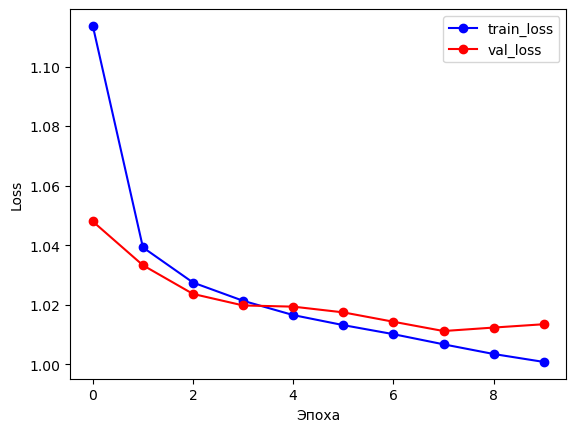

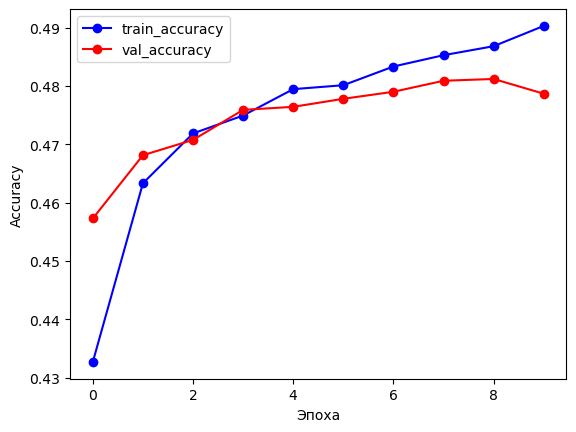

In [15]:
# Визуализация результатов
# График потерь
plt.plot(history.history['loss'],'bo-', label='train_loss')
plt.plot(history.history['val_loss'], 'ro-', label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
plt.plot(history.history['accuracy'], 'bo-', label='train_accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='val_accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
#проверка на тестовой выьорке
loss_test, acc_test = model.evaluate( [q_test, s_test],  a_test)
print('Test accuracy: ', acc_test)
print('Test loss: ', loss_test)


7219/7219 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.4800 - loss: 1.0161
Test accuracy:  0.47986769676208496
Test loss:  1.0157829523086548
